# Assignment 3
### 1) Colors separation and reconstruction
Use an existing library to separate the three channels of your RGB image and show each of them separately.

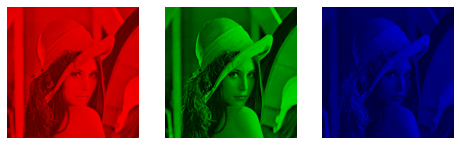

In [142]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

# Read image and convert to RGB
img_bgr = cv2.imread("./images/lena.png")
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Split R, G, B
r, g, b = cv2.split(img)

# Set other channels to 0 to display
z = np.zeros(r.shape, np.uint8)

# Plot
_, axes = plt.subplots(1, 3, figsize=(8, 8))
[axi.set_axis_off() for axi in axes]
axes[0].imshow(cv2.merge([r, z, z]))
axes[1].imshow(cv2.merge([z, g, z]))
axes[2].imshow(cv2.merge([z, z, b]))
plt.show()

Write your own algorithm to convert an RGB image to HSL and the inverse.

In [143]:
def rgb_2_hsl(p):
   Cmax = max(p / 255)
   Cmin = min(p / 255)
   d = Cmax - Cmin
   r, g, b = p / 255

   # Hue
   if d == 0:
      h = 0
   elif Cmax == r:
      h = 60 * (((g - b) / d) % 6)
   elif Cmax == g:
      h = 60 * (((b - r) / d) + 2)
   else:
      h = 60 * (((r - g) / d) + 4)

   # Lightness
   l = (Cmax + Cmin) / 2.

   # Saturation
   s = 0 if d == 0 else d / (1 - abs(2 * l - 1))

   return h, s, l

def hsl_2_rgb(p):
   h, s, l = p 
   c = (1 - abs(2 * l - 1)) * s
   x = c * (1 - abs(((h / 60.) % 2) - 1))
   m = l - c / 2

   if 0 <= h < 60:
      r, g, b = c, x, 0
   elif 60 <= h < 120:
      r, g, b = x, c, 0
   elif 120 <= h < 180:
      r, g, b = 0, c, x
   elif 180 <= h < 240:
      r, g, b = 0, x, c
   elif 240 <= h < 300:
      r, g, b = x, 0, c
   else:
      r, g, b = c, 0, x

   return np.uint8(((r, g, b) + m) * 255)

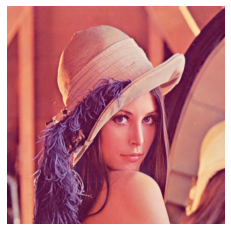

In [144]:
# Create image with HSL
img_hsl = np.zeros(img.shape)
for x in range(img_hsl.shape[0]):
   for y in range(img_hsl.shape[1]):
      img_hsl[x, y] = rgb_2_hsl(img[x, y])

# Create RGB image from HSL image
img_hsl2rgb = np.zeros(img_hsl.shape, np.uint8)
for x in range(img_hsl.shape[0]):
   for y in range(img_hsl.shape[1]):
      img_hsl2rgb[x, y] = hsl_2_rgb(img_hsl[x, y])

plt.imshow(img_hsl2rgb)
plt.axis("off")
plt.show()

### 2) Greyscale Histogram Equalization
Write your own histogram equalization algorithm based on the method presented in the lecture.

In [145]:
def histogram(img):
    histo = np.zeros(256, np.uint16)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            histo[img[x, y]] += 1

    return histo

def cumul_sum(hist):
    res = hist.copy()
    for i, v in enumerate(hist):
        res[i:] += v
    return res

def hist_equalization(img):
    # Histogram
    hist = histogram(img)
    normalized_hist = hist / (img.shape[0] * img.shape[1])

    # Cumulative histogram
    cumulative_hist = cumul_sum(normalized_hist)

    # Pixel mapping lookup table
    transform_map = np.floor(256 * cumulative_hist).astype(np.uint8)

    # Create equalized image
    img_eq = np.zeros(img.shape, np.uint8)
    for x in range(img.shape[0]):
        for y in range(img.shape[1]):
            img_eq[x, y] = transform_map[img[x, y]]

    return img_eq

Apply your algorithm on the greyscale images.

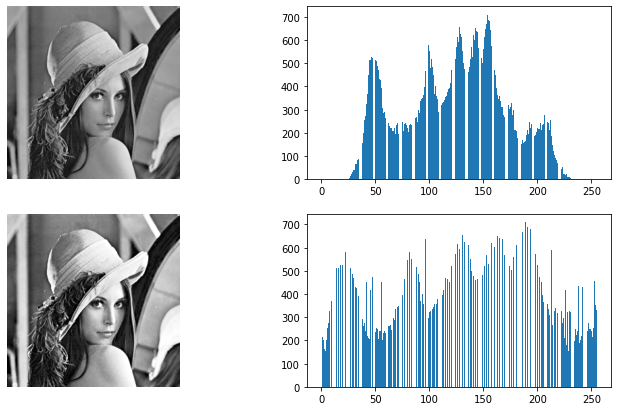

In [146]:
# Load gray image and apply histogram equalization
img_gray = cv2.imread("./images/lena_gray.png", cv2.IMREAD_GRAYSCALE)
img_eq = hist_equalization(img_gray)

# Plot histograms and images
_, axes = plt.subplots(2, 2, figsize=(12, 7))
axes[0][0].imshow(img_gray, cmap="gray")
axes[1][0].imshow(img_eq, cmap="gray")
axes[0][0].axis("off")
axes[1][0].axis("off")

axes[0][1].bar(range(256), histogram(img_gray))
axes[1][1].bar(range(256), histogram(img_eq))
# plt.savefig("images/results/assignment_3_grayscale.png")
plt.show()

### 3) Color Histogram Equalization
Apply your histogram equalization algorithm on the R, G, and B channels and reconstruct your image.

Apply the histogram equalization on the L channel of your HSL image and
reconstruct your image with the new L channel and the original H and S channels.
Convert the result on an RGB image.

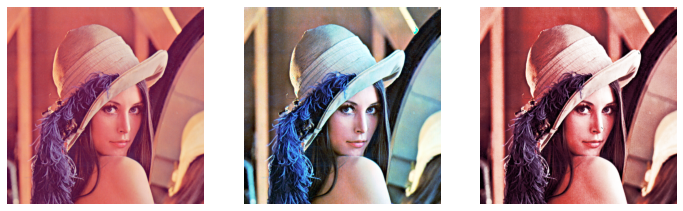

In [147]:
# Apply histogram equalization on RGB image
r,g,b = cv2.split(img)
img_rgb_eq = cv2.merge([hist_equalization(r), hist_equalization(g), hist_equalization(b)])

# Apply histogram equalization on the lightness of an HSL image
h, s, l = cv2.split(img_hsl)
L = hist_equalization(np.uint8(l * 255))
img_hsl_eq = cv2.merge([h, s, L / 255])

# Reconstruct RGB image from HSL image
img_hsl2rgb_eq = np.zeros(img_hsl_eq.shape, np.uint8)
for x in range(img_hsl_eq.shape[0]):
   for y in range(img_hsl_eq.shape[1]):
      img_hsl2rgb_eq[x, y] = hsl_2_rgb(img_hsl_eq[x, y])

# Plot the 3 images
fig, axes = plt.subplots(1, 3, figsize=(12, 7))
[axi.set_axis_off() for axi in axes]
axes[0].imshow(img)
axes[1].imshow(img_rgb_eq)
axes[2].imshow(img_hsl2rgb_eq)
# plt.savefig("images/results/assignment_3_equalization.png")
plt.show()

Visually compare the result of the two images after equalizing the histograms (RGB
and HSL). What can you observe?

The change of L will influence the luminous effect by keeping the hue which is defined by H. We therefore have an image with very bright areas and very dark areas.
The equalization on the r, g, b does not respect the initial color of the pixels because they are modified separately without keeping their "proportion" which gives an image with another hue.

### Description of algorithme
To convert HSL to RGB and vice versa, I just took the formulas provided in the course and I implemented them in 2 functions.

For the histogram equalization, my algorithm is separated into 3 components:
- Normalized histogram: the different values of each pixel are counted in a list and then the values are normalized.
- Normalized cumulative histogram
- Lookup table: gives a value to each pixel depending on the cumulative histogram. With this lookup table, the equalized image is then created.

With lightness, the continous value are convert the discrete value between [0, 255] before using the equalization function and then it reconverts to continous between [0, 1].